<a href="https://colab.research.google.com/github/ihabiba/ML-customer-analysis/blob/main/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning: Customer Segmentation using K-Means Clustering


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [2]:
# Load the dataset
df = pd.read_csv("Datasets/data.csv", encoding='ISO-8859-1')

In [3]:
# Check dataset shape
print("Initial shape:", df.shape)

Initial shape: (541909, 8)


In [4]:
# Check for missing values
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# Drop rows with missing values to clean the data
df.dropna(inplace=True)

In [6]:
#confirm missing values are dropped
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
#  Drop unusable and irrelevant columns
df.drop(columns=[ 'Description', 'CustomerID'], inplace=True)

In [8]:
#  Convert InvoiceDate and extract time-based features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceWeekday'] = df['InvoiceDate'].dt.weekday
df.drop(columns=['InvoiceDate'], inplace=True)

In [9]:
# One-hot encode the 'Country' column
df = pd.get_dummies(df, columns=['Country'], drop_first=True)


In [10]:
# Frequency encode 'StockCode'
stock_freq = df['StockCode'].value_counts()
df['StockCode_encoded'] = df['StockCode'].map(stock_freq)
df.drop(columns=['StockCode'], inplace=True)

In [11]:
# Frequency encode 'InvoiceNo'
invoice_freq = df['InvoiceNo'].value_counts()
df['InvoiceNo_encoded'] = df['InvoiceNo'].map(invoice_freq)
df.drop(columns=['InvoiceNo'], inplace=True)

In [12]:
#check data head
df.head()

,Quantity,UnitPrice,InvoiceHour,InvoiceDay,InvoiceMonth,InvoiceWeekday,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,...,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,StockCode_encoded,InvoiceNo_encoded
0,6,2.55,8,1,12,2,False,False,False,False,...,False,False,False,False,False,False,True,False,2077,7
1,6,3.39,8,1,12,2,False,False,False,False,...,False,False,False,False,False,False,True,False,272,7
2,8,2.75,8,1,12,2,False,False,False,False,...,False,False,False,False,False,False,True,False,250,7
3,6,3.39,8,1,12,2,False,False,False,False,...,False,False,False,False,False,False,True,False,330,7
4,6,3.39,8,1,12,2,False,False,False,False,...,False,False,False,False,False,False,True,False,333,7


In [13]:
# Keep original DataFrame unchanged (will be used for interpretation later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Create a new DataFrame for the scaled data
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)


In [14]:
#using pca to retain minimum number of features  while still retaining 95% of the total variance in the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(X_scaled)
print(f"Number of components retained: {pca.n_components_}")

Number of components retained: 41


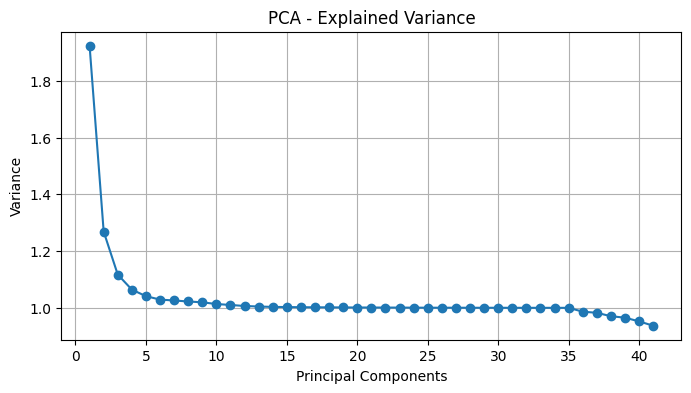

In [15]:
# Plot explained variance (scree plot)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.title('PCA - Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance')
plt.grid(True)
plt.savefig('assets/pca_explained_variance.png') # Save plot
plt.show()

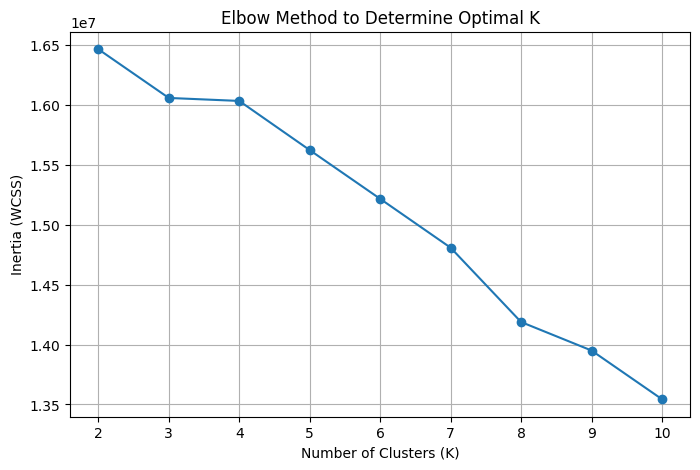

In [16]:
# Determine optimal number of clusters using Elbow Method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method to Determine Optimal K")
plt.grid(True)
plt.savefig('assets/elbow_method.png') # Save plot
plt.show()

In [17]:
# Try silhouette scores to support best K selection
# Sample 10,000 rows once from your PCA-reduced data for efficiency
sample_size = 10000
total_rows = pca_features.shape[0]
idx = np.random.choice(total_rows, sample_size, replace=False)
pca_sample = pca_features[idx]

# List to store silhouette scores
silhouette_scores = []
k_values = range(2, 11)

# Loop through different K values and compute silhouette score
print("Silhouette Scores (sample of 10,000):")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_sample)
    score = silhouette_score(pca_sample, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.3f}")


Silhouette Scores (sample of 10,000):
K=2: Silhouette Score = 0.841
K=3: Silhouette Score = 0.677
K=4: Silhouette Score = 0.679
K=5: Silhouette Score = 0.130
K=6: Silhouette Score = 0.133
K=7: Silhouette Score = 0.136
K=8: Silhouette Score = 0.543
K=9: Silhouette Score = 0.546
K=10: Silhouette Score = 0.548


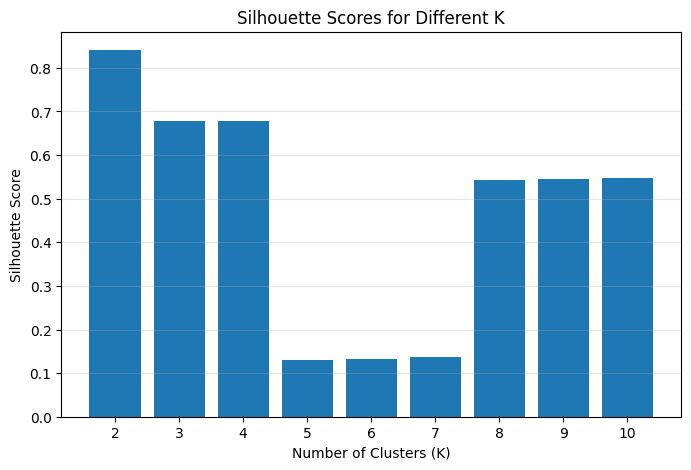

In [18]:
# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.bar(k_values, silhouette_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different K")
plt.xticks(k_values)
plt.grid(axis='y', alpha=0.3)
plt.savefig('assets/silhouette_scores_bar.png') # Save plot
plt.show()

In [19]:
# Based on elbow and silhouette, use K=3
best_k = 3

# Apply KMeans clustering
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(pca_features)

# (Optional) Add cluster labels to your PCA DataFrame
import pandas as pd

pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
pca_df['Cluster'] = clusters


In [20]:
# Use original unscaled data
df_with_clusters = df.copy()  # unscaled version for interpretation
df_with_clusters['Cluster'] = clusters  # clusters from KMeans on PCA-reduced data
df_with_clusters['Estimated_Spend'] = df_with_clusters['Quantity'] * df_with_clusters['UnitPrice'] # Calculate Estimated_Spend for each row

# Compute mean values per cluster
cluster_summary = df_with_clusters.groupby('Cluster')[['Quantity', 'UnitPrice', 'Estimated_Spend']].mean()

# Display cluster summary sorted by spend
print(cluster_summary.sort_values(by='Estimated_Spend'))

           Quantity  UnitPrice  Estimated_Spend
Cluster                                        
0         10.663878   3.148114        18.149099
1         16.281666   6.164547        28.260500
2        149.742099   2.737324       223.478609


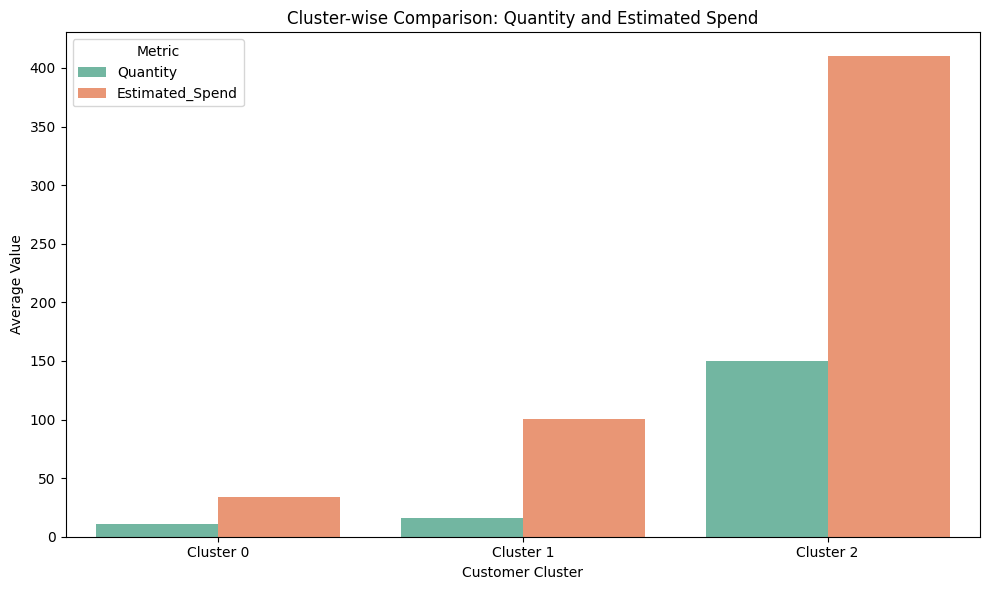

In [21]:
# Bar Chart Comparing Average Quantity and Estimated Spend Across Customer Clusters
# Create the summary DataFrame
cluster_summary = pd.DataFrame({
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2'],
    'Quantity': [10.66, 16.28, 149.74],
    'Estimated_Spend': [33.57, 100.37, 409.89]
})

# Melt the DataFrame for grouped bar plot
df_melted = cluster_summary.melt(id_vars='Cluster', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Cluster', y='Value', hue='Metric', palette='Set2')
plt.title('Cluster-wise Comparison: Quantity and Estimated Spend')
plt.ylabel('Average Value')
plt.xlabel('Customer Cluster')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('assets/cluster_comparison_quantity_spend.png') # Save plot
plt.show()

In [22]:
# Create a mapping for customer types
cluster_map = {
    0: 'Group 1: Low Spenders',
    1: 'Group 2: Regular Customers',
    2: 'Group 3: High-Value Customers'
}

# Apply to your PCA DataFrame
pca_df['Customer Type'] = pca_df['Cluster'].map(cluster_map)

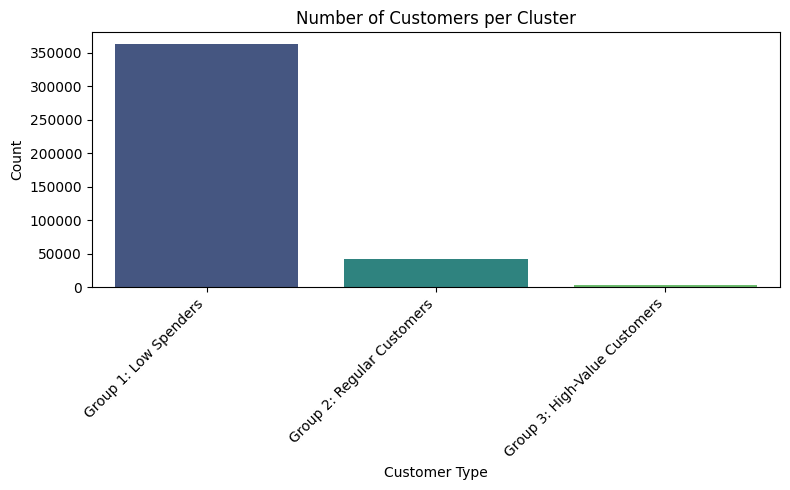

In [23]:
# Plot the distribution of customers per cluster
plt.figure(figsize=(8,5))
sns.countplot(x='Customer Type', data=pca_df, hue='Customer Type', palette='viridis', legend=False)
plt.title("Number of Customers per Cluster")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('assets/customers_per_cluster_count.png')
plt.show()

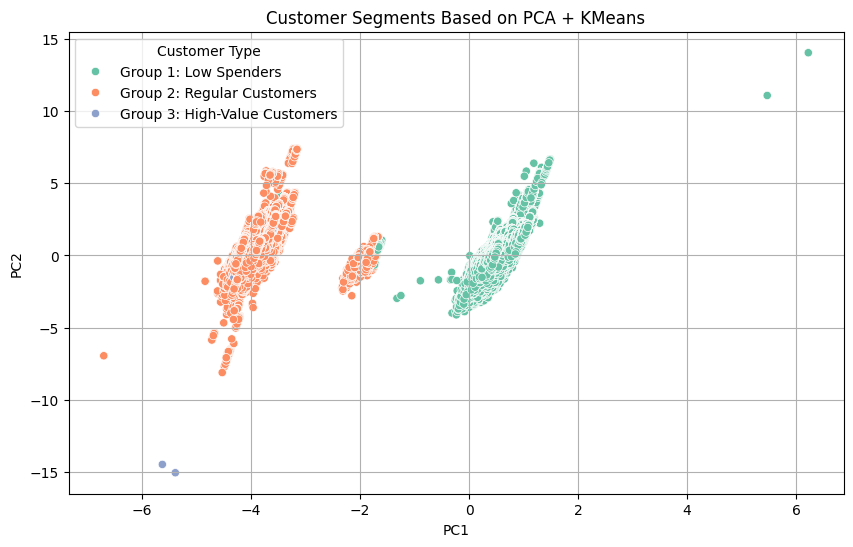

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Customer Type',
    palette='Set2'
)
plt.title('Customer Segments Based on PCA + KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.legend(title='Customer Type')
plt.savefig('assets/pca_2d_scatter.png') # Save plot
plt.show()

### 3D PCA Scatter Plot

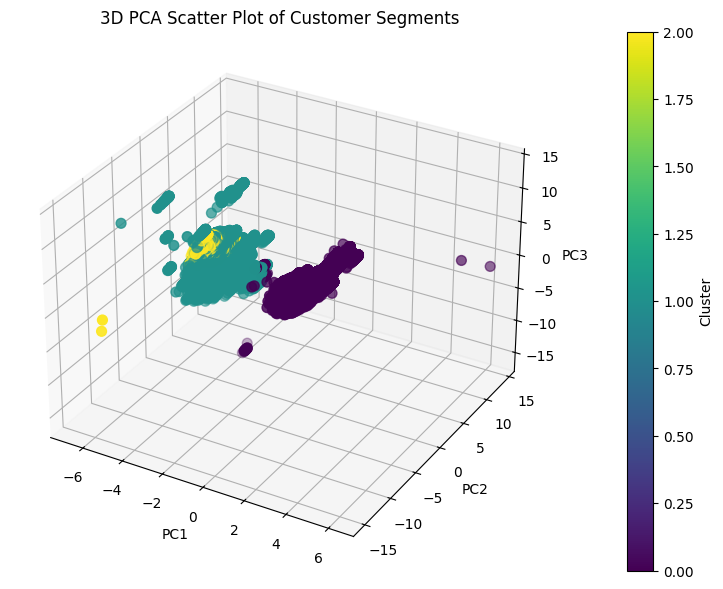

In [25]:
# Import for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Map clusters to customer types for better legend in 3D plot if possible, or use cluster numbers
# For simplicity, let's use cluster numbers for 'c' and rely on default color mapping first.
# If a specific categorical mapping for 'c' is needed, we'd convert 'Customer Type' to numerical labels.
# For now, using raw cluster numbers, as 'cmap' will handle it.

scatter = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    pca_df['PC3'],
    c=pca_df['Cluster'],
    cmap='viridis',
    s=50
)

ax.set_title("3D PCA Scatter Plot of Customer Segments")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Add a color bar to indicate clusters
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster')

plt.savefig('assets/pca_3d_scatter.png') # Save plot
plt.show()

In [26]:
# Export models and artifacts for Streamlit app
import joblib
import os

os.makedirs('models', exist_ok=True)

# Save the KMeans model
joblib.dump(kmeans, 'models/segments_kmeans.pkl')

# Save the scaler
joblib.dump(scaler, 'models/segments_scaler.pkl')

# Save the PCA transformer
joblib.dump(pca, 'models/segments_pca.pkl')

# Save the feature columns (for input preprocessing)
joblib.dump(df.columns.tolist(), 'models/segments_features.pkl')

# Save the cluster mapping
joblib.dump(cluster_map, 'models/segments_cluster_map.pkl')

# Save cluster summary stats
cluster_stats = {
    0: {'name': 'Low Spenders', 'avg_quantity': 10.66, 'avg_spend': 33.57},
    1: {'name': 'Regular Customers', 'avg_quantity': 16.28, 'avg_spend': 100.37},
    2: {'name': 'High-Value Customers', 'avg_quantity': 149.74, 'avg_spend': 409.89}
}
joblib.dump(cluster_stats, 'models/segments_cluster_stats.pkl')

print("All segmentation models exported successfully!")
print(f"- KMeans model: models/segments_kmeans.pkl")
print(f"- Scaler: models/segments_scaler.pkl")
print(f"- PCA: models/segments_pca.pkl")
print(f"- Features: models/segments_features.pkl")
print(f"- Cluster map: models/segments_cluster_map.pkl")
print(f"- Cluster stats: models/segments_cluster_stats.pkl")

All segmentation models exported successfully!
- KMeans model: models/segments_kmeans.pkl
- Scaler: models/segments_scaler.pkl
- PCA: models/segments_pca.pkl
- Features: models/segments_features.pkl
- Cluster map: models/segments_cluster_map.pkl
- Cluster stats: models/segments_cluster_stats.pkl
